In [315]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")

<h2>Import data</h2>
We manually set up headers and types for better accuracy and control over them.<br/>
parse_dates is used to convert the date into a datetime object type<br/>
sep=';' specifies that the values are separated by a ';' symbol in the .csv file<br/>
skiprows=1 skips the 1st row of the .csv file as that's the headers<br/>

In [316]:
#import data
headers = ['time_utc','asset_group_id','active_power','predicted_active_power','possible_power','wind_speed','rpm','active_stop','control_state_id','online_data_expired','wind_direction','temperature','active_stop_user_id','prediction_id']

parse_dates = ['time_utc']
df = pd.read_csv("../AssetsData/online_data.csv", sep=';', names=headers, parse_dates=parse_dates, skiprows=1)
df.head()


time_utc  asset_group_id active_power  \
0 2021-10-29 23:09:01.357              67    1.055.600   
1 2021-10-29 23:09:06.084              60       -7.300   
2 2021-10-29 23:09:06.084              98       -7.000   
3 2021-10-29 23:09:06.084              62       -8.600   
4 2021-10-29 23:09:06.084              34       -7.300   

   predicted_active_power possible_power  wind_speed     rpm active_stop  \
0                     NaN      1.363.400        10.1  1662.1           f   
1                     NaN      1.172.600         7.6    56.3           t   
2                     NaN      1.768.800         8.7    64.0           t   
3                     NaN      1.648.000         8.5    42.4           t   
4                     NaN      2.204.400         9.4    77.6           t   

   control_state_id online_data_expired  wind_direction  temperature  \
0               2.0                   f           192.0         13.0   
1               1.0                   f           185.0         13.0   
2               1.0                   f           192.0         12.0   
3               1.0                   f           192.0         12.0   
4               1.0                   f           172.0         12.0   

   active_stop_user_id  prediction_id  
0                  NaN            0.0  
1                  1.0            0.0  
2                  1.0            0.0  
3                  1.0            0.0  
4                  1.0            0.0

In [317]:
#drop useless column based on NETRA's suggestions
df.drop(columns=['prediction_id', 'possible_power', 'predicted_active_power', 'active_stop_user_id'], inplace=True, axis=1)
print(f"Amount of N/A values in the data frame: {df.isna().sum().sum()}")

Amount of N/A values in the data frame: 567979


<h2>Handle missing values</h2>

In [318]:
#drop rows with missing values
df.dropna(subset=['wind_speed', 'temperature', 'wind_direction'], inplace=True, axis=0)

#replace negative values with 0 to ...
# Get names of indexes for which column rpm is below 0
indexNames = df[df['rpm'] < 0 ].index

# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
print(f"Amount of N/A values in the data frame: {df.isna().sum().sum()}")

Amount of N/A values in the data frame: 0


<h2>Data formatting</h2>

In [319]:
df.columns = ['time_utc','id','active_power_kw','wind_speed_ms','rpm','active_stopped','control_state_id','online_data_expired','wind_direction_degrees','temperature']

df.replace(['f', 't'], [0, 1], inplace=True)
df['active_power_kw'] = df['active_power_kw'].replace('\.','', regex=True).astype(float).astype('int32')

dtypes = {
    'id':np.uint8,
    'wind_speed_ms':np.float32,
    'rpm':np.int64,
    'active_stopped':np.uint8,
    'control_state_id':np.uint8,
    'online_data_expired':np.uint8,
    'wind_direction_degrees':np.float32,
    'temperature':np.float32
}
df = df.astype(dtypes)
df.info()

indexNames = df[df['active_power_kw'] < 0 ].index
df.drop(indexNames , inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794104 entries, 0 to 1048551
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time_utc                794104 non-null  datetime64[ns]
 1   id                      794104 non-null  uint8         
 2   active_power_kw         794104 non-null  int32         
 3   wind_speed_ms           794104 non-null  float32       
 4   rpm                     794104 non-null  int64         
 5   active_stopped          794104 non-null  uint8         
 6   control_state_id        794104 non-null  uint8         
 7   online_data_expired     794104 non-null  uint8         
 8   wind_direction_degrees  794104 non-null  float32       
 9   temperature             794104 non-null  float32       
dtypes: datetime64[ns](1), float32(3), int32(1), int64(1), uint8(4)
memory usage: 33.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 556668 entries, 

<h2>Data preprocessing</h2>

In [320]:
#split control_state_id in 5 different columns with 0 & 1 values
df = pd.get_dummies(df, columns=['control_state_id'], prefix='control_state', drop_first = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556668 entries, 0 to 1048547
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time_utc                556668 non-null  datetime64[ns]
 1   id                      556668 non-null  uint8         
 2   active_power_kw         556668 non-null  int32         
 3   wind_speed_ms           556668 non-null  float32       
 4   rpm                     556668 non-null  int64         
 5   active_stopped          556668 non-null  uint8         
 6   online_data_expired     556668 non-null  uint8         
 7   wind_direction_degrees  556668 non-null  float32       
 8   temperature             556668 non-null  float32       
 9   control_state_2         556668 non-null  uint8         
 10  control_state_5         556668 non-null  uint8         
 11  control_state_6         556668 non-null  uint8         
 12  control_state_7         55666

In [321]:
# move active_power to the last column
df = df[['time_utc','id','wind_speed_ms','rpm','wind_direction_degrees','temperature','control_state_2','control_state_5','control_state_6','control_state_7','active_power_kw']]
# and rename the control state ids to more meaningful values
df.rename(columns={'control_state_2':'control_state_running','control_state_5':'control_state_stopping','control_state_6':'control_state_foreign_stop','control_state_7':'control_state_starting'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556668 entries, 0 to 1048547
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time_utc                    556668 non-null  datetime64[ns]
 1   id                          556668 non-null  uint8         
 2   wind_speed_ms               556668 non-null  float32       
 3   rpm                         556668 non-null  int64         
 4   wind_direction_degrees      556668 non-null  float32       
 5   temperature                 556668 non-null  float32       
 6   control_state_running       556668 non-null  uint8         
 7   control_state_stopping      556668 non-null  uint8         
 8   control_state_foreign_stop  556668 non-null  uint8         
 9   control_state_starting      556668 non-null  uint8         
 10  active_power_kw             556668 non-null  int32         
dtypes: datetime64[ns](1), float32(3), int3

We plot histograms of the values that we want to normalize to decide on a mathematical normalization function

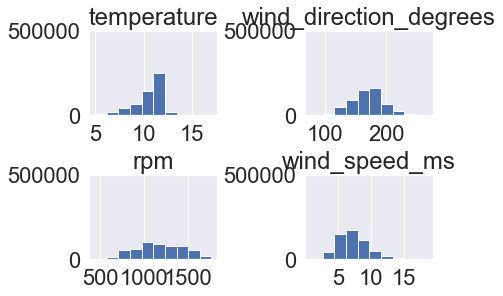

In [322]:
# histograms after normalization
y_axis_max = 500000
def subplot_hists():
    figure, axis = plt.subplots(2, 2, constrained_layout = True)

    # For Sine Function
    #sns.histplot(data=df['temperature'].astype(np.int32), kde=True, ax=axis[0, 0], binwidth=1)
    axis[0, 0].hist(df['temperature'])
    axis[0, 0].set_title("temperature")
    axis[0, 0].set_ylim([0, y_axis_max])

    # For Cosine Function
    axis[0, 1].hist(df['wind_direction_degrees'])
    axis[0, 1].set_title("wind_direction_degrees")
    axis[0, 1].set_ylim([0, y_axis_max])

    # For Tangent Function
    axis[1, 0].hist(df['rpm'])
    axis[1, 0].set_title("rpm")
    axis[1, 0].set_ylim([0, y_axis_max])

    # For Tanh Function
    axis[1, 1].hist(df['wind_speed_ms'])
    axis[1, 1].set_title("wind_speed_ms")
    axis[1, 1].set_ylim([0, y_axis_max])

    # Combine all the operations and display
    plt.show()

subplot_hists()

In [323]:
# Based on the above histogram the folliwng normalizations were applied
# normalize the values

# linear clipping (min/max) for flat value destribution
df['rpm'] = (df['rpm']-df['rpm'].min())/(df['rpm'].max()-df['rpm'].min())   

# normalize with sin values of the degrees for circular values
df['wind_direction_degrees'] = np.sin(np.deg2rad(df['wind_direction_degrees']))
    
# z-score for already bell-like spread values
for column in ['temperature','wind_speed_ms']:
    df[column]=(df[column]-df[column].mean())/df[column].std()

df.head()

time_utc  id  wind_speed_ms       rpm  \
0  2021-10-29 23:09:01.357  67       1.307010  0.920394   
34 2021-10-29 23:09:00.000  79      -0.529740  0.582259   
35 2021-10-29 23:09:00.000  93      -0.667496  0.529189   
36 2021-10-29 23:09:00.000   4       0.204960  0.620167   
37 2021-10-29 23:09:00.000  95       0.664147  0.757392   

    wind_direction_degrees  temperature  control_state_running  \
0                -0.207912     1.841676                      1   
34                0.190809     0.489036                      1   
35                0.087156     0.489036                      1   
36                0.390731     1.165356                      1   
37                0.087156     0.489036                      1   

    control_state_stopping  control_state_foreign_stop  \
0                        0                           0   
34                       0                           0   
35                       0                           0   
36                       0                           0   
37                       0                           0   

    control_state_starting  active_power_kw  
0                        0          1055600  
34                       0          1043100  
35                       0          1082900  
36                       0          1409300  
37                       0          2348500

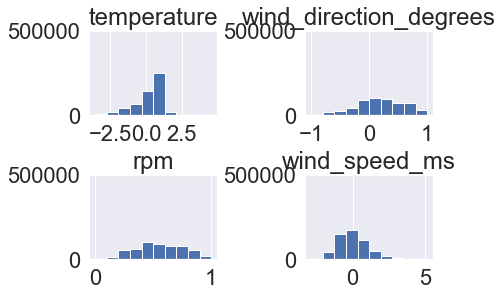

In [324]:
subplot_hists()

<h1>Exploratory Data Analysis</h1>
<h2>Descriptive statistics</h2>
Let's check what is the description of the dataframe right now


In [325]:
df.describe().apply(lambda s: s.apply('{0:.10f}'.format))

id      wind_speed_ms                rpm  \
count  556668.0000000000  556668.0000000000  556668.0000000000   
mean       49.6125446406      -0.0000000491       0.5574143245   
std        29.1886824538       0.9999999404       0.1999720685   
min         1.0000000000      -2.8715960979       0.0000000000   
25%        21.0000000000      -0.7134152055       0.4094010614   
50%        50.0000000000      -0.1164714471       0.5549658832   
75%        76.0000000000       0.6182286143       0.7316148597   
max       100.0000000000       5.1641840935       1.0000000000   

      wind_direction_degrees        temperature control_state_running  \
count      556668.0000000000  556668.0000000000     556668.0000000000   
mean            0.1811811924      -0.0000000228          0.9988215597   
std             0.4030678272       0.9999999404          0.0343082160   
min            -0.9986295104      -3.5688829422          0.0000000000   
25%            -0.0871558115      -0.1872835010          1.0000000000   
50%             0.1736482829      -0.1872835010          1.0000000000   
75%             0.4848095775       0.4890364110          1.0000000000   
max             1.0000000000       4.5469555855          1.0000000000   

      control_state_stopping control_state_foreign_stop  \
count      556668.0000000000          556668.0000000000   
mean            0.0002029935               0.0000592813   
std             0.0142461463               0.0076992134   
min             0.0000000000               0.0000000000   
25%             0.0000000000               0.0000000000   
50%             0.0000000000               0.0000000000   
75%             0.0000000000               0.0000000000   
max             1.0000000000               1.0000000000   

      control_state_starting     active_power_kw  
count      556668.0000000000   556668.0000000000  
mean            0.0005550885  1176139.8039765174  
std             0.0235537972   926148.8964010454  
min             0.0000000000        0.0000000000  
25%             0.0000000000   455475.0000000000  
50%             0.0000000000   897500.0000000000  
75%             0.0000000000  1675900.0000000000  
max             1.0000000000  3732400.0000000000

The wind direction, wind speed and temperature have a mean of around 0 and a standard deviation of 1. The rpm is normalized using the min-max method.


In [326]:
answer = input('Run all the regplot? (y/n)') == 'y'

if answer:
    sns.regplot(x = "wind_speed_ms", y = "active_power_kw", data = df, scatter_kws={"color": '#2074b4'}, line_kws={"color": "red"}).set(title='Linear Relationship between active power & wind speed')
    plt.xlabel("Wind Speed")
    plt.ylabel("Active Power")
    plt.show()

we can see a clear linear relationship between windspeed and active power

In [327]:
if answer:
    sns.regplot(x="temperature", y = "active_power_kw", data = df, scatter_kws={"color": '#2074b4'}, line_kws={"color": "red"}).set(title="LR between active power & temperature")
    plt.xlabel("Temperature")
    plt.ylabel("Active Power")
    plt.show()

In [328]:
if answer:
    sns.regplot(x="wind_direction_degrees", y = "active_power_kw", data = df, scatter_kws={"color": '#2074b4'}, line_kws={"color": "red"}).set(title='LR between wind direction & active power')
    plt.xlabel("Wind Direction")
    plt.ylabel("Active Power")
    plt.show()

In [329]:
if answer:
    sns.regplot(x="rpm", y = "active_power_kw", data = df, scatter_kws={"color": '#2074b4'}, line_kws={"color": "red"}).set(title='LR between RPM & active power')
    plt.xlabel("RPM")
    plt.ylabel("Active Power")
    plt.show()

In [330]:
#control_state_running
if answer:
    sns.regplot(x="control_state_running", y = "active_power_kw", data = df, scatter_kws={"color": '#2074b4'}, line_kws={"color": "red"}).set(title='LR between CS "Running" & active power')
    plt.xlabel("Control State Running")
    plt.ylabel("Active Power")
    plt.show()

In [331]:
from scipy import stats
import matplotlib.pyplot as plt
pearson_coef, p_value = stats.pearsonr(df['wind_speed_ms'], df['active_power_kw'])
print('Wind Speed')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

pearson_coef, p_value = stats.pearsonr(df['wind_direction_degrees'], df['active_power_kw'])
print('Wind Direction')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

pearson_coef, p_value = stats.pearsonr(df['rpm'], df['active_power_kw'])
print('RPM')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

pearson_coef, p_value = stats.pearsonr(df['temperature'], df['active_power_kw'])
print('Temperature')
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)



Wind Speed
The Pearson Correlation Coefficient is 0.8880428119434919  with a P-value of P = 0.0
Wind Direction
The Pearson Correlation Coefficient is 0.14910904814744005  with a P-value of P = 0.0
RPM
The Pearson Correlation Coefficient is 0.7424947494536694  with a P-value of P = 0.0
Temperature
The Pearson Correlation Coefficient is 0.24449637962853213  with a P-value of P = 0.0


array([ 67,  79,  93,   4,  95,  17,  72,  23,  51,  70,  81,  57,  29,
        49,  45,  76,  94,  43,   1,  86,  65,  19,  92,  55,  35,  14,
        84,  77,  71,  20,  42,  21,  68,  88,   6,  50,   9,  60,  98,
        34,  62, 100,   7,  59,  89,  85,  83,  12,   5,  40,  16,  48,
        13,  10,  46,  32,  66,  38,  54,  63,  15,  31,  91,  73,  11,
        90,  30,  18,  37,  28,  22,  56,   2,  61,  36,  78,  44],
      dtype=uint8)

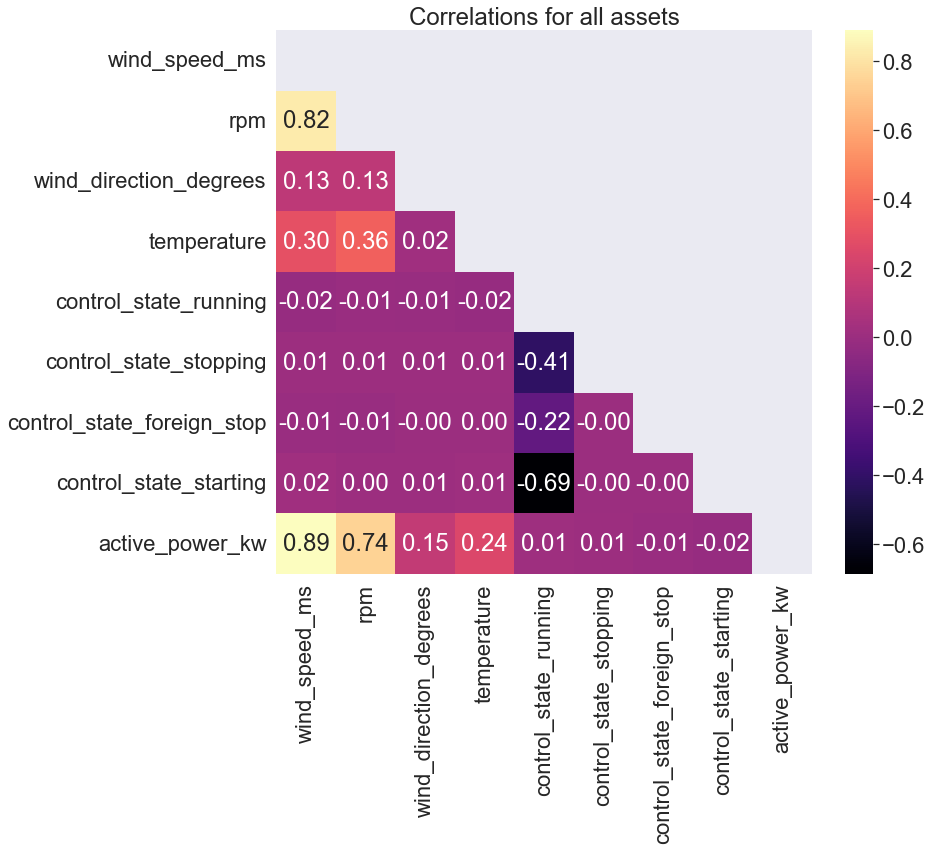

In [342]:
plt.figure(figsize=(12,10))
corr1 = df.drop(columns=['id'], axis=1).corr()
p = sns.heatmap(corr1,annot=True,cmap="magma",fmt='.2f',mask=np.triu(np.ones_like(corr1, dtype=bool)))
p.set(title = "Correlations for all assets")
df.id.unique()

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'wind_speed'),
  Text(1.5, 0, 'temperature'),
  Text(2.5, 0, 'wind_direction'),
  Text(3.5, 0, 'rpm'),
  Text(4.5, 0, 'active_power')])

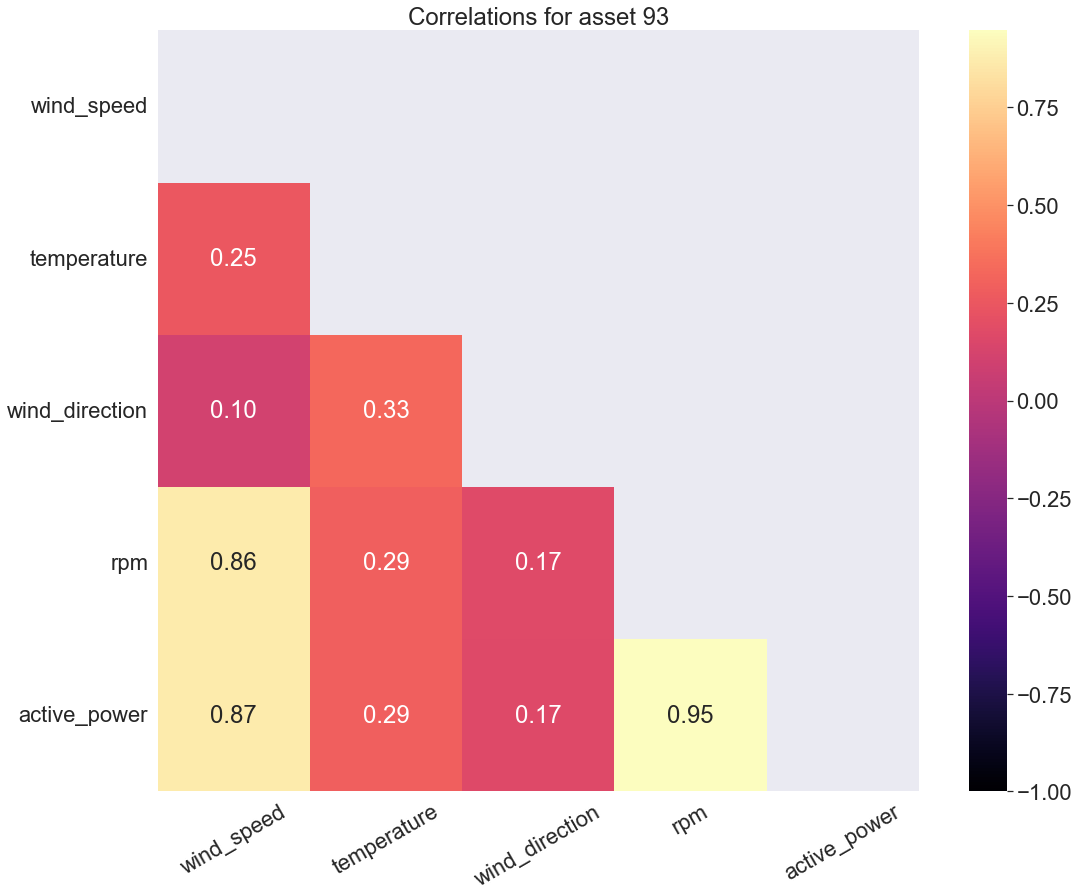

In [352]:
plt.figure(figsize=(18,14))
corr = df[df["id"]==93]
corr = corr.drop(columns=['id', 'control_state_running', 'control_state_stopping', 'control_state_foreign_stop', 'control_state_starting'], axis=1)
corr.rename(columns = {'wind_direction_degrees':'wind_direction', 'active_power_kw':'active_power','wind_speed_ms':'wind_speed'}, inplace = True)
corr = corr.reindex(columns=["wind_speed", "temperature", "wind_direction", "rpm", "active_power"]).corr()
p = sns.heatmap(corr,annot=True, vmin=-1,cmap="magma",square=True,fmt='.2f', mask=np.triu(np.ones_like(corr, dtype=bool)))
sns.set(font_scale=2)
p.set(title = "Correlations for asset 93")
plt.yticks(rotation=0)
plt.xticks(rotation=30)

In [334]:
df.to_csv("../online_data/formatted_data_new.csv")

In [335]:
coefs = []
for assetId in df['id'].unique():
    pearson_coef, p_value = stats.pearsonr(df[df.id == assetId]['wind_direction_degrees'], df[df.id == assetId]['active_power_kw'])
    coefs.append(pearson_coef)

coefs = np.abs(coefs)
print(np.mean(coefs))
pearson_coef, p_value = stats.pearsonr(df['wind_direction_degrees'], df['active_power_kw'])
print(pearson_coef)


0.18488440475592594
0.14910904814744005
